#**Install Dependencies and Import Libraries**

In [3]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import splitfolders
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

#**Mount Google Drive to Google Colab**

In [5]:
#Mounting google drive folders to colab, so we can access them
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Preprocessing Data**

In [14]:
#directory Dataset in google drive
BASE_DIR = "gdrive/MyDrive/Capstone/Dataset"

#Checking all folder consist in Base dir
!ls "gdrive/MyDrive/Capstone/Dataset"

Dermatofibroma	Jerawat  Kurap	Kusta  Kutil  Panu  Sehat


###**Split Data**

In [15]:
#Split Dataset in google drive to 3 folders (train, val, test) and use google colab temporary storage
splitfolders.ratio(input = BASE_DIR, output = "Dataset",seed = 42,ratio = (.7,.2,.1))

Copying files: 1627 files [00:17, 92.12 files/s] 


In [16]:
#Specify Training, Validation, adn Test data directory in google colab temporary storage
TRAINING_DIR = 'Dataset/train'
VALIDATION_DIR = 'Dataset/val'
TEST_DIR = 'Dataset/test'

###**Image-Preprocessing**

In [17]:
#Augmentation for training dataset
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

#Generated batches contain augmented and normalized training data
train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 32,
                                                      class_mode = 'categorical',
                                                      target_size = (300, 300))


#Augmentation for validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255.,
                                        rotation_range = 40,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        fill_mode = 'nearest')

#Generated batches contain augmented and normalized training data
validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 16,
                                                                class_mode = 'categorical',
                                                                shuffle=False,
                                                                target_size = (300, 300))


#Augmentation for test dataset
test_datagen = ImageDataGenerator(rescale = 1./255.,
                                        rotation_range = 40,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        fill_mode = 'nearest')

#Generated batches contain augmented and normalized training data
test_generator = test_datagen.flow_from_directory(directory = TEST_DIR,
                                                                batch_size = 16,
                                                                class_mode = 'categorical',
                                                                shuffle=False,
                                                                target_size = (300, 300))

Found 1110 images belonging to 7 classes.
Found 321 images belonging to 7 classes.
Found 160 images belonging to 7 classes.


###**Listing Labels**

In [18]:
#Make list of labels
labels = list(train_generator.class_indices.keys())
print(labels)

['Dermatofibroma', 'Jerawat', 'Kurap', 'Kusta', 'Kutil', 'Panu', 'Sehat']


#**Built the model**

In [31]:
#Importing InceptionV3 for the base model
base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')

In [32]:
#Adding new layers to the models
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
outputs = tf.keras.layers.Dense(7,activation='softmax')(x)
model = tf.keras.Model(inputs = base_model.input, outputs = outputs)

In [33]:
#Model compile with Adam optimizer, and categorical_crossentropy for the loss
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [34]:
#Start training the model, and save the history
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
35/35 [==============================] - 96s 1s/step - loss: 1.0168 - accuracy: 0.6541 - val_loss: 0.5584 - val_accuracy: 0.8131
Epoch 2/15
35/35 [==============================] - 45s 1s/step - loss: 0.3197 - accuracy: 0.8964 - val_loss: 0.2721 - val_accuracy: 0.9190
Epoch 3/15
35/35 [==============================] - 42s 1s/step - loss: 0.1977 - accuracy: 0.9333 - val_loss: 0.2976 - val_accuracy: 0.9034
Epoch 4/15
35/35 [==============================] - 41s 1s/step - loss: 0.1372 - accuracy: 0.9532 - val_loss: 0.1894 - val_accuracy: 0.9470
Epoch 5/15
35/35 [==============================] - 41s 1s/step - loss: 0.1082 - accuracy: 0.9730 - val_loss: 0.1116 - val_accuracy: 0.9564
Epoch 6/15
35/35 [==============================] - 42s 1s/step - loss: 0.0750 - accuracy: 0.9775 - val_loss: 0.1811 - val_accuracy: 0.9470
Epoch 7/15
35/35 [==============================] - 41s 1s/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 0.2350 - val_accuracy: 0.9439
Epoch 8/15
35/35 [==

#**Plot Accuracy and Loss**

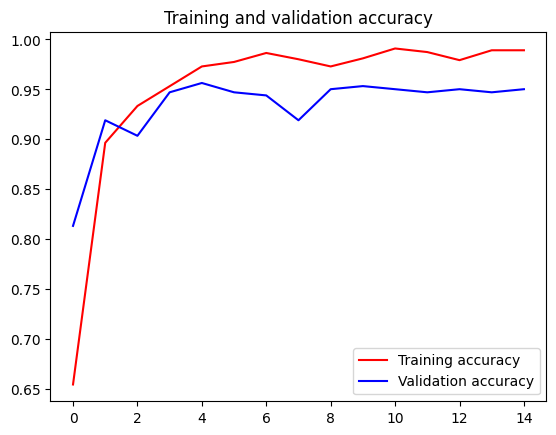

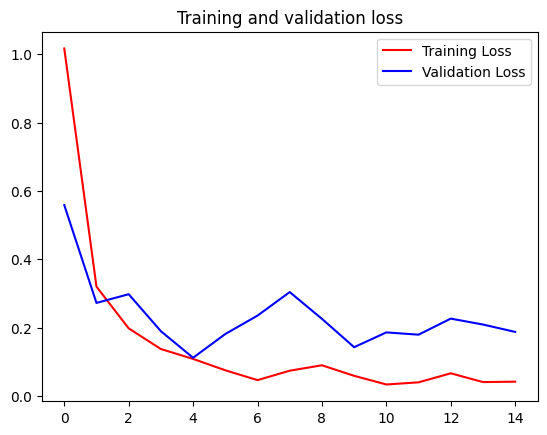

In [35]:
#Prepare requirentment for ploting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the model history
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#**Confusion Matrix**

21/21 [==============================] - 9s 359ms/step


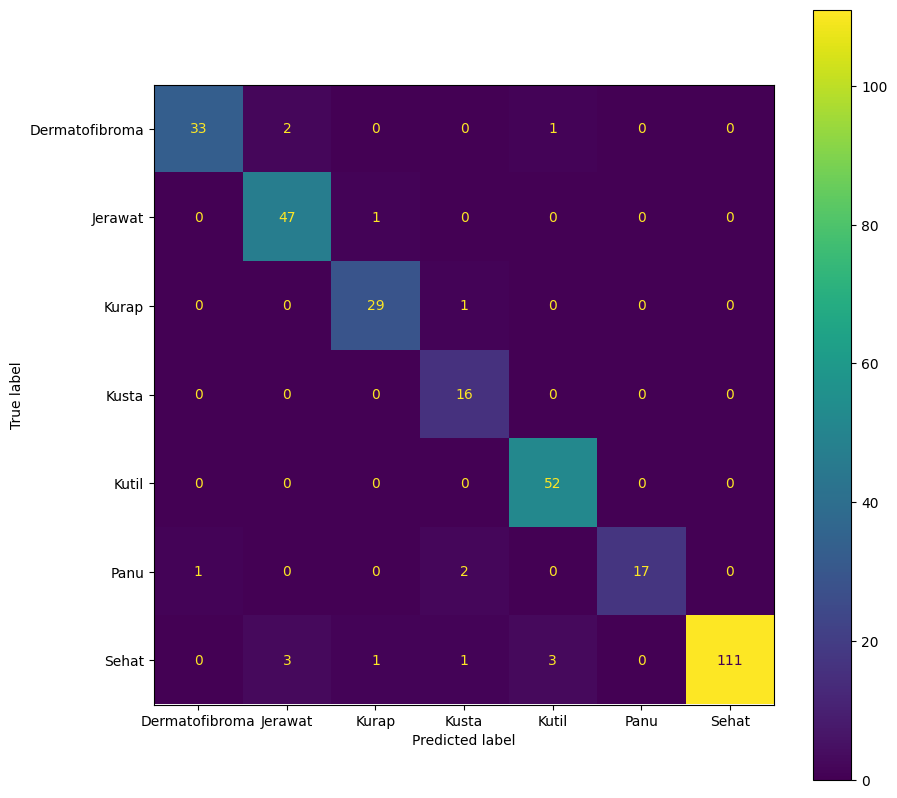

In [36]:
#Make Confusion Matrix for the validation data
y_probs = model.predict(validation_generator)
y_preds = y_probs.argmax(axis=1)

cm=confusion_matrix(y_preds,validation_generator.classes)

#Plot the Confustion Matrix
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

#**Model Evaluation**

In [37]:
#Evaluate model score using test data
score = model.evaluate(test_generator)
print(score)

10/10 [==============================] - 5s 429ms/step - loss: 0.2581 - accuracy: 0.9375
[0.25814616680145264, 0.9375]


10/10 [==============================] - 4s 384ms/step


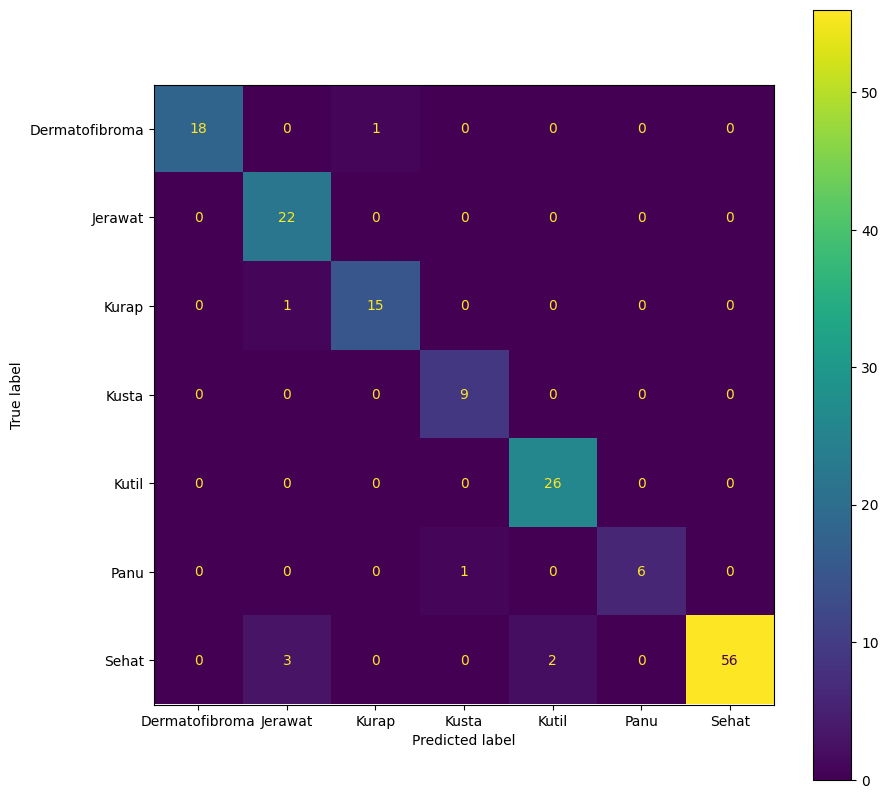

In [38]:
#Make Confusion Matrix for the validation data
y_probs_test = model.predict(test_generator)
y_preds_test = y_probs_test.argmax(axis=1)

cm=confusion_matrix(y_preds_test,test_generator.classes)

#Plot the Confustion Matrix
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

#**Save and Download the model**

In [ ]:
#Save the model in google colab temporary storage
model_name = 'Skinease_6.h5'

model.save(model_name)

In [ ]:
#Import files from google.colab library to download model
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>